# PROJET 7

In [14]:
import mlflow
# demarrage d'une "expérience" 
mlflow.set_experiment("Risk Scoring")

<Experiment: artifact_location='file:///Users/danongohou/Desktop/DataScience/P7-CreditScoring/mlruns/466049582382335734', creation_time=1685640953574, experiment_id='466049582382335734', last_update_time=1685640953574, lifecycle_stage='active', name='Risk Scoring', tags={}>

In [15]:
mlflow.start_run(run_name='Features Importance')

<ActiveRun: >

In [16]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from dataprep import eda
import qgrid
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import joblib 
from numba import njit
from numba import generated_jit
from numba import types

%matplotlib inline 

import gc
import time
from contextlib import contextmanager
# File system manangement
import os
import os.path
from os import path 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification

from collections import Counter

from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks

import scipy.stats as stats
from sklearn.metrics import confusion_matrix, make_scorer


from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
import shap
import pickle
import joblib

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

bleu = (70 / 255, 130 / 255, 180 / 255)
pd.set_option('display.max_row', 219)
pd.set_option('display.max_column', 243)
pd.set_option('display.max_colwidth', 50)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

## LGBM

In [17]:
with open('./data/lgbm_final.pkl', 'rb') as f:
    model_lgbm = pickle.load(f)

## Explicabilité Globale

In [18]:
# Charger les descripteurs ORB extraits dans la question précédente
with open('./data/data_for_modelling_final.pickle', 'rb') as f:
    data_for_modelling = pickle.load(f)

In [19]:
data_for_modelling.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE_Cashloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,...,PREV_NAME_PAYMENT_TYPE_Cashlessfromtheaccountoftheemployer_MEAN,PREV_NAME_PAYMENT_TYPE_Noncashfromyouraccount_MEAN,PREV_NAME_PAYMENT_TYPE_nan_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_SYSTEM_MEAN,PREV_CODE_REJECT_REASON_VERIF_MEAN,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_CODE_REJECT_REASON_nan_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN,PREV_NAME_TYPE_SUITE_Other_A_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_CLIENT_TYPE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_AdditionalService_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_AudioVid

In [20]:
X = data_for_modelling.copy()
y = X['TARGET']
X.drop(columns=['TARGET'],inplace=True)

X_test,X_train,y_test,y_train=train_test_split(X,y,test_size=0.20)

# StandardScaler
# Fit on the training data
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

## Explicabilité Globale

100%|===================| 227658/227912 [11:58<00:00]        

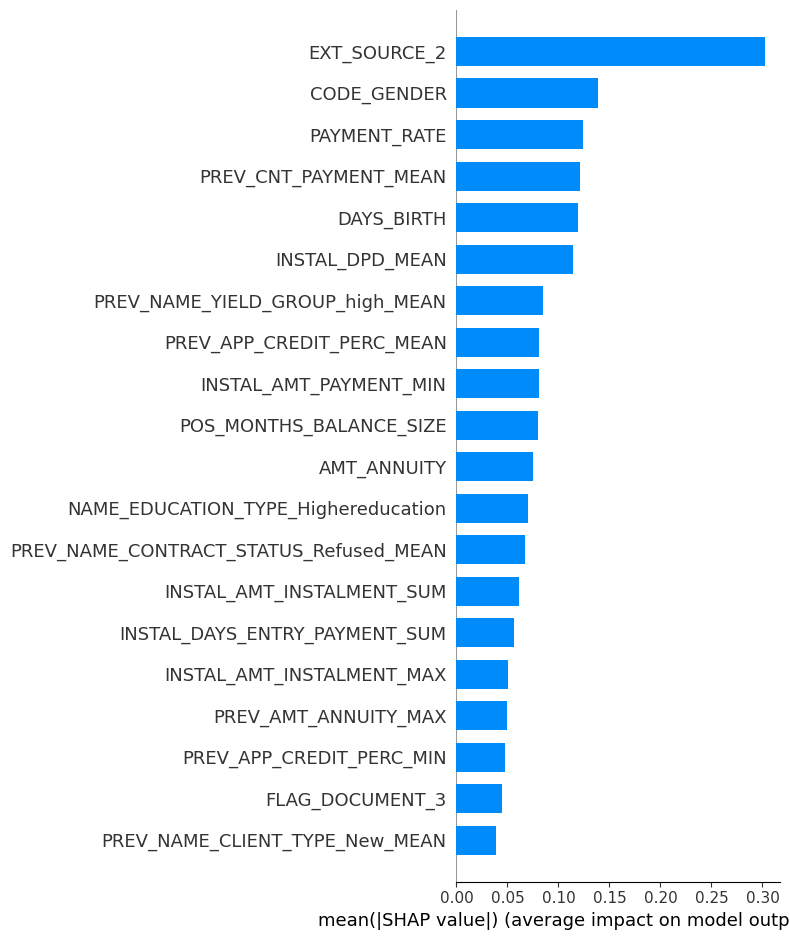

In [10]:
shap.initjs()
feats = [f for f in data_for_modelling.columns if f not in ['TARGET']]

expl = shap.TreeExplainer(model_lgbm, X_train, feature_names = np.array(feats), max_display=40)
shap_values = expl.shap_values(X_test)

shap.summary_plot(shap_values, feats, max_display=20, plot_type='bar')

## Explicabilité Locale : Client à l'index 15

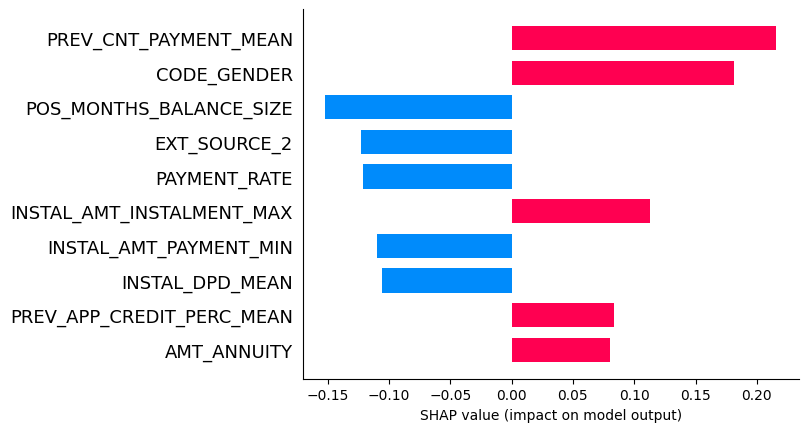

In [13]:
shap.bar_plot(expl.shap_values(X_test[15]), feature_names = np.array(feats), max_display=10)

In [21]:
mlflow.end_run()

In [ ]:
!mlflow ui 

[2023-05-31 14:57:35 +0200] [4911] [INFO] Starting gunicorn 20.1.0
[2023-05-31 14:57:35 +0200] [4911] [INFO] Listening at: http://127.0.0.1:5000 (4911)
[2023-05-31 14:57:35 +0200] [4911] [INFO] Using worker: sync
[2023-05-31 14:57:35 +0200] [4912] [INFO] Booting worker with pid: 4912
[2023-05-31 14:57:35 +0200] [4913] [INFO] Booting worker with pid: 4913
[2023-05-31 14:57:35 +0200] [4914] [INFO] Booting worker with pid: 4914
[2023-05-31 14:57:35 +0200] [4915] [INFO] Booting worker with pid: 4915
[2023-05-31 15:37:06 +0200] [4911] [CRITICAL] WORKER TIMEOUT (pid:4912)
[2023-05-31 15:37:06 +0200] [4911] [CRITICAL] WORKER TIMEOUT (pid:4913)
[2023-05-31 15:37:06 +0200] [4911] [CRITICAL] WORKER TIMEOUT (pid:4914)
[2023-05-31 15:37:06 +0200] [4911] [CRITICAL] WORKER TIMEOUT (pid:4915)
[2023-05-31 15:37:06 +0200] [4912] [INFO] Worker exiting (pid: 4912)
[2023-05-31 15:37:06 +0200] [4913] [INFO] Worker exiting (pid: 4913)
[2023-05-31 15:37:06 +0200] [4914] [INFO] Worker exiting (pid: 4914)
[202